In [89]:
import metpy.calc as mpcalc

import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from herbie import FastHerbie
from scores.continuous import rmse, mae
from scores.spatial import fss_2d

import cdsapi
import os

### calculate the temperature gradient in the forecasts, calculate FSS on the gradient

In [90]:
init = pd.Timestamp(2022,12,21,0)

### define region of interest:
#latmin=33.5
#latmax=45.25
#lonmin=-110.7 + 360
#lonmax=-93.0 + 360

latmin = 32.
latmax = 44.
lonmin = -104.5 + 360
lonmax = -97.0 + 360


### read in model data

In [91]:
### read the gefs netcdf
gefs_all = xr.open_dataset("gefs_all_"+init.strftime("%Y%m%d%H")+".nc")
### hard-coding the times here
gefs_all = gefs_all.isel(step=range(3,7))

### and bring in AI models
pangu_2m = xr.open_dataset("cira_ai_output/pangu_t2_subset_"+init.strftime("%Y%m%d%H")+".nc")
gc_2m = xr.open_dataset("cira_ai_output/gc_t2_subset_"+init.strftime("%Y%m%d%H")+".nc")
fcn_2m = xr.open_dataset("cira_ai_output/fcn_t2_subset_"+init.strftime("%Y%m%d%H")+".nc")

### get GFS
DATES = pd.date_range(
    start=init.strftime("%Y-%m-%d %H:%M"),
    periods=1,freq="1d")

# Create a range of forecast lead times
#fxx_start = int((pd.Timestamp(2022,12,21,0) - init)/pd.Timedelta(hours=1))
#fxx_end = int((pd.Timestamp(2022,12,23,6) - init)/pd.Timedelta(hours=1))
fxx_start = int((pd.Timestamp(2022,12,21,18) - init)/pd.Timedelta(hours=1))
fxx_end = int((pd.Timestamp(2022,12,22,18) - init)/pd.Timedelta(hours=1))
fh_fxx = range(fxx_start, fxx_end, 6)   

FH = FastHerbie(DATES, model="gfs", product="pgrb2.0p25", fxx=fh_fxx)
gfs = FH.xarray("TMP:2 m above", remove_grib=False)

### get era5 if needed
try:
    era5 = xr.open_dataset("era5_dec2022_verf.nc")
except:
    client = cdsapi.Client()
    
    dataset = "reanalysis-era5-single-levels"
    request = {
        "product_type": ["reanalysis"],
        "variable": [
            "10m_u_component_of_wind",
            "10m_v_component_of_wind",
            "2m_temperature",
            "mean_sea_level_pressure"
        ],
        "year": ["2022"],
        "month": ["12"],
        "day": ["21", "22", "23"],
        "time": [
            "00:00", "06:00", "12:00",
            "18:00"
        ],
        "data_format": "netcdf",
        "area": [55, -125, 20, -70]
    }
    
    client.retrieve(dataset, request,
                   "era5_dec2022_verf.nc")


### reshape the data as needed

In [92]:
verf_times = pd.date_range(start='2022-12-21 18:00',
                           end='2022-12-22 12:00', freq='6h')

era5_sub = era5.sel(longitude=slice(lonmin-360,lonmax-360), latitude=slice(latmax,latmin)).sel(valid_time=verf_times)
## make era5 lon consistent with all the models
era5_sub['longitude'] = era5_sub['longitude'] + 360.
era5_sub = era5_sub.drop_vars(['number','expver'])

gc_sub = gc_2m.sel(longitude=slice(lonmin,lonmax), latitude=slice(latmax,latmin)).sel(time=verf_times)
gc_sub = gc_sub.rename({'time':'valid_time'})

pangu_sub = pangu_2m.sel(longitude=slice(lonmin,lonmax), latitude=slice(latmax,latmin)).sel(time=verf_times)
pangu_sub = pangu_sub.rename({'time':'valid_time'})

fcn_sub = fcn_2m.sel(longitude=slice(lonmin,lonmax), latitude=slice(latmax,latmin)).sel(time=verf_times)
fcn_sub = fcn_sub.rename({'time':'valid_time'})

### reshape gfs from init,step to valid_time as dimension
gfs_sub = gfs.sel(longitude=slice(lonmin,lonmax), latitude=slice(latmax,latmin))
gfs_reshape = xr.DataArray(data=gfs_sub.t2m.values,
                         dims=['valid_time','latitude','longitude'],
                         coords=dict(
                             longitude=('longitude',gfs_sub.longitude.values),
                             latitude=('latitude',gfs_sub.latitude.values),
                             valid_time=('valid_time',gfs_sub.valid_time.values))).to_dataset(name='t2m')

## same for gefs
gefs_sub = gefs_all.sel(longitude=slice(lonmin,lonmax), latitude=slice(latmax,latmin))
gefs_reshape = xr.DataArray(data=gefs_sub.t2m.values,
                         dims=['number','valid_time','latitude','longitude'],
                         coords=dict(
                             number=('number',gefs_sub.number.values),
                             longitude=('longitude',gfs_sub.longitude.values),
                             latitude=('latitude',gfs_sub.latitude.values),
                             valid_time=('valid_time',gfs_sub.valid_time.values))).to_dataset(name='t2m')

gefsmean_reshape = gefs_reshape.mean(dim='number')


gefsmean_reshape

<xarray.Dataset> Size: 25kB
Dimensions:     (longitude: 31, latitude: 49, valid_time: 4)
Coordinates:
  * longitude   (longitude) float64 248B 255.5 255.8 256.0 ... 262.5 262.8 263.0
  * latitude    (latitude) float64 392B 44.0 43.75 43.5 ... 32.5 32.25 32.0
  * valid_time  (valid_time) datetime64[ns] 32B 2022-12-21T18:00:00 ... 2022-...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 24kB 249.2 ... 279.3

### calculate temperature gradient

In [93]:
### calculate gradients

era5_grad = 1e4*((mpcalc.geospatial_gradient(era5_sub.t2m)[0]**2 + mpcalc.geospatial_gradient(era5_sub.t2m)[1]**2)**0.5)
era5_sub['t2m_grad'] = (('valid_time', 'latitude', 'longitude'), era5_grad.magnitude)

pangu_grad = 1e4*((mpcalc.geospatial_gradient(pangu_sub.t2)[0]**2 + mpcalc.geospatial_gradient(pangu_sub.t2)[1]**2)**0.5)
pangu_sub['t2m_grad'] = (('valid_time', 'latitude', 'longitude'), pangu_grad.magnitude)

gc_grad = 1e4*((mpcalc.geospatial_gradient(gc_sub.t2)[0]**2 + mpcalc.geospatial_gradient(gc_sub.t2)[1]**2)**0.5)
gc_sub['t2m_grad'] = (('valid_time', 'latitude', 'longitude'), gc_grad.magnitude)

fcn_grad = 1e4*((mpcalc.geospatial_gradient(fcn_sub.t2)[0]**2 + mpcalc.geospatial_gradient(fcn_sub.t2)[1]**2)**0.5)
fcn_sub['t2m_grad'] = (('valid_time', 'latitude', 'longitude'), fcn_grad.magnitude)

gfs_grad = 1e4*((mpcalc.geospatial_gradient(gfs_reshape.t2m)[0]**2 + mpcalc.geospatial_gradient(gfs_reshape.t2m)[1]**2)**0.5)
gfs_reshape['t2m_grad'] = (('valid_time', 'latitude', 'longitude'), gfs_grad.magnitude)

gefs_grad = 1e4*((mpcalc.geospatial_gradient(gefs_reshape.t2m)[0]**2 + mpcalc.geospatial_gradient(gefs_reshape.t2m)[1]**2)**0.5)
gefs_reshape['t2m_grad'] = (('number','valid_time', 'latitude', 'longitude'), gefs_grad.magnitude)

#gefsmean_grad = 1e4*((mpcalc.geospatial_gradient(gefsmean_reshape.t2m)[0]**2 + mpcalc.geospatial_gradient(gefsmean_reshape.t2m)[1]**2)**0.5)
#gefsmean_reshape['t2m_grad'] = (('valid_time', 'latitude', 'longitude'), gefsmean_grad.magnitude)
gefsmean_reshape['t2m_grad'] = gefs_reshape.t2m_grad.mean(dim='number')



### now set up and calculate FSS

In [94]:
threshold = 0.8
window_size = (3, 3)
#window_size = (10,10)

models = ['Pangu','GraphCast','FCNv2','GFS','GEFS mean']
ds_dict = {'Pangu':pangu_sub, 'GraphCast':gc_sub,
           'FCNv2':fcn_sub,'GFS':gfs_reshape,
           'GEFS mean':gefsmean_reshape,
           'GEFS':gefs_reshape}

for model in models:
    fcst_ds = ds_dict[model]
    
    fss_out = fss_2d(
        fcst_ds.t2m_grad,
        era5_sub.t2m_grad,
        event_threshold=threshold,
        window_size=window_size,
        spatial_dims=["longitude", "latitude"],
        preserve_dims=["valid_time"]
    ).to_dataframe()
    fss_out['model'] = model

    #print(model, ", "+str(fss_out.values))
    if model==models[0]:
        fss_all = fss_out
    else:
        fss_all = pd.concat([fss_all,fss_out])

### and do the gefs

model = "GEFS" 
fcst_ds = ds_dict[model]

fss_out = fss_2d(
    fcst_ds.t2m_grad,
    era5_sub.t2m_grad,
    event_threshold=threshold,
    window_size=window_size,
    spatial_dims=["longitude", "latitude"],
    preserve_dims=["number","valid_time"]
).to_dataframe().reset_index().set_index('valid_time')
fss_out['model'] = fss_out.number

#print(model, ", "+str(fss_out.values))
fss_all = pd.concat([fss_all,fss_out])
#fss_alltimes = pd.concat([fss_alltimes,fss_out_alltimes])


In [95]:
fss_pivot = fss_all.reset_index().pivot(index='model',
                            columns='valid_time', values='t2m_grad')

fss_pivot.columns = fss_pivot.columns.strftime('%HZ/%d')  ### format time

### reorder rows to put AI models at top
fss_pivot = fss_pivot.reindex(['FCNv2', 'Pangu', 'GraphCast', 'GFS', 'GEFS mean', 0, 1, 2,
       3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

fss_pivot['mean'] = fss_pivot.mean(axis=1)  ### also the mean over times

fss_pivot.to_csv("fss_pivot_"+init.strftime("%Y%m%d%H")+"_window"+str(window_size[0])+".csv")

fss_pivot

valid_time,18Z/21,00Z/22,06Z/22,12Z/22,mean
model,,,,,
FCNv2,0.625637,0.330399,0.284886,0.185597,0.356630
Pangu,0.770542,0.663649,0.768523,0.710591,0.728326
GraphCast,0.667155,0.565241,0.430430,0.835744,0.624642
GFS,0.800590,0.750052,0.533953,0.572768,0.664341
GEFS mean,0.850189,0.767828,0.653668,0.637859,0.727386
0,0.813197,0.755090,0.757283,0.812567,0.784534
1,0.834158,0.672966,0.324956,0.542690,0.593692
2,0.780867,0.578550,0.334329,0.414369,0.527029
3,0.658552,0.521318,0.657256,0.724595,0.640430


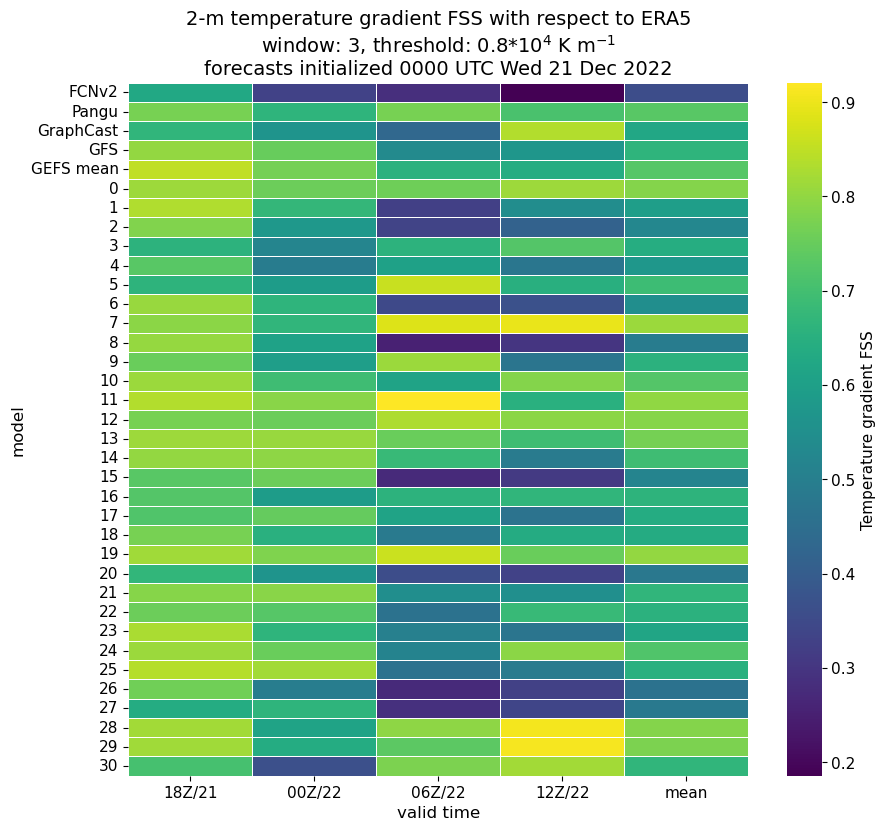

In [96]:
fig, ax = plt.subplots(figsize=(10,9))

sns.heatmap(fss_pivot, cmap='viridis', #annot=True,
        #   vmin=-20, vmax=20, 
            ax=ax, linewidth=0.5)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label='Temperature gradient FSS', size=11)

ax.set_title("2-m temperature gradient FSS with respect to ERA5\nwindow: "+str(window_size[0])+", threshold: "+str(threshold)+"$*10^4$ K m$^{-1}$\nforecasts initialized "+init.strftime("%H%M UTC %a %d %b %Y"),
            fontsize=14)

ax.set_xlabel("valid time", fontsize=12)
ax.set_ylabel("model", fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=11)

plt.savefig("aiwp_images/"+init.strftime("%Y%m%d%H/")+"t2m_fss_window"+str(window_size[0])+"_heatmap.png")
plt.show()

plt.close('all')

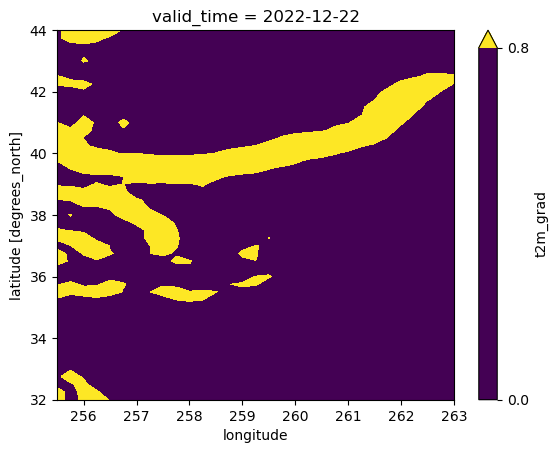

In [97]:
era5_sub.t2m_grad.isel(valid_time=1).plot.contourf(levels=[0,0.8])

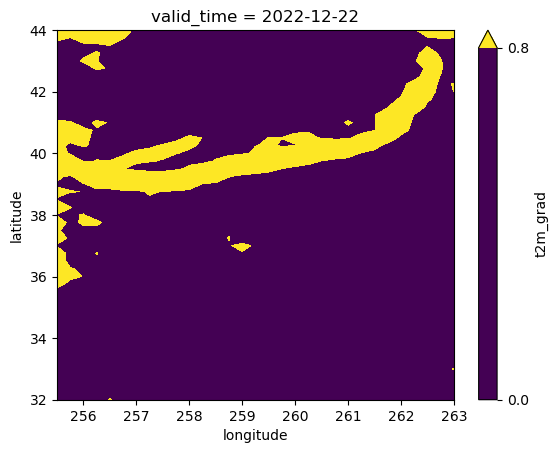

In [98]:
gfs_reshape.t2m_grad.isel(valid_time=1).plot.contourf(levels=[0,0.8])

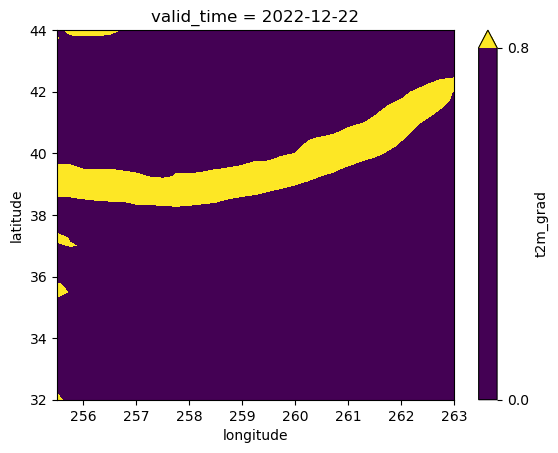

In [99]:
gc_sub.t2m_grad.isel(valid_time=1).plot.contourf(levels=[0,0.8])